In [55]:
import pandas as pd
from prophet import Prophet

In [56]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from datetime import datetime
from datetime import timedelta
from time import time
# from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
%matplotlib inline

In [57]:
import warnings
warnings.filterwarnings('ignore')

### Create some useful functions

In [58]:
def specific_time(df, start, end):
    time=(df['Date']>start) & (df['Date']<=end)
    df=df.loc[time]
    plt.figure(figsize=(10, 5))
    figure=sns.lineplot(x='Date', y='Price', data=df)

In [59]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [60]:
def test_stationarity(ts):
    
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()

    
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
   
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts['Price'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [61]:
# import os
# os.chdir('Downloads')

### Importing dataset

In [62]:
df = pd.read_excel("BrentOil.xlsx")
df.tail()

,Date,Price
9029,2022-12-13,80.14
9030,2022-12-14,83.33
9031,2022-12-15,82.34
9032,2022-12-16,80.20
9033,2022-12-19,81.66


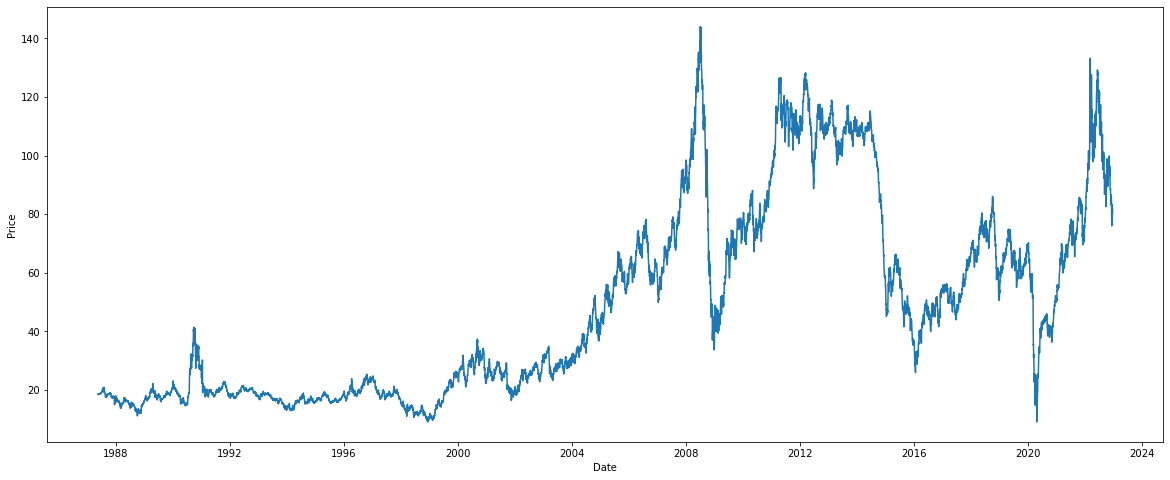

In [63]:
plt.figure(figsize = (20,8))
sns.lineplot(x='Date', y ='Price',data = df)
plt.show()

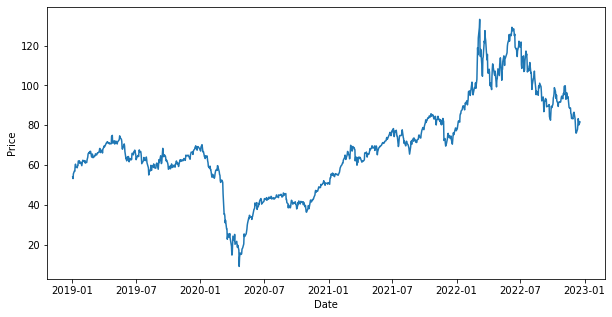

In [64]:
specific_time(df, '2019-01-01', '2022-12-19')

### Note that Prophet requires the date column as 'ds' and outcome varible as 'y'. So we change this in our dataframe and check its data.

In [65]:
model_df = df
model_df.columns = ['ds','y']
model_df.head()

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


# Forecasting Models

## FB Prophet

### Next we fit this dataframe into the model object created and then create a forecast for the Oil Price for the next 90 days.

In [66]:
model = Prophet(daily_seasonality = True)
model.fit(model_df)

### We check the forecast data has several components - trend, weakly and yearly seasonality - and for each of these components, we have the lower and upper confidence intervals data.

In [67]:
model_forecast = model.make_future_dataframe(periods = 90)
forecast = model.predict(model_forecast)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1987-05-20,17.865490,4.068959,30.226774,17.865490,17.865490,-0.707572,-0.707572,-0.707572,-2.056163,...,-0.153538,-0.153538,-0.153538,1.502130,1.502130,1.502130,0.0,0.0,0.0,17.157918
1,1987-05-21,17.869549,3.132410,30.844685,17.869549,17.869549,-0.556199,-0.556199,-0.556199,-2.056163,...,-0.033946,-0.033946,-0.033946,1.533910,1.533910,1.533910,0.0,0.0,0.0,17.313350
2,1987-05-22,17.873608,3.282515,31.140135,17.873608,17.873608,-0.575582,-0.575582,-0.575582,-2.056163,...,-0.080173,-0.080173,-0.080173,1.560754,1.560754,1.560754,0.0,0.0,0.0,17.298025
3,1987-05-25,17.885784,3.169379,30.496342,17.885784,17.885784,-0.513086,-0.513086,-0.513086,-2.056163,...,-0.069118,-0.069118,-0.069118,1.612195,1.612195,1.612195,0.0,0.0,0.0,17.372698
4,1987-05-26,17.889843,3.631359,31.243137,17.889843,17.889843,-0.613195,-0.613195,-0.613195,-2.056163,...,-0.177266,-0.177266,-0.177266,1.620235,1.620235,1.620235,0.0,0.0,0.0,17.276649


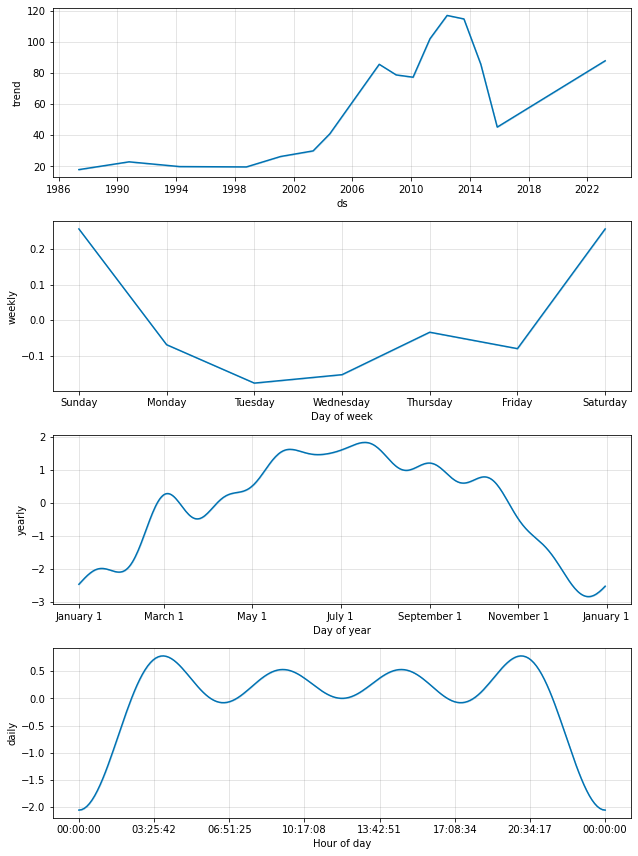

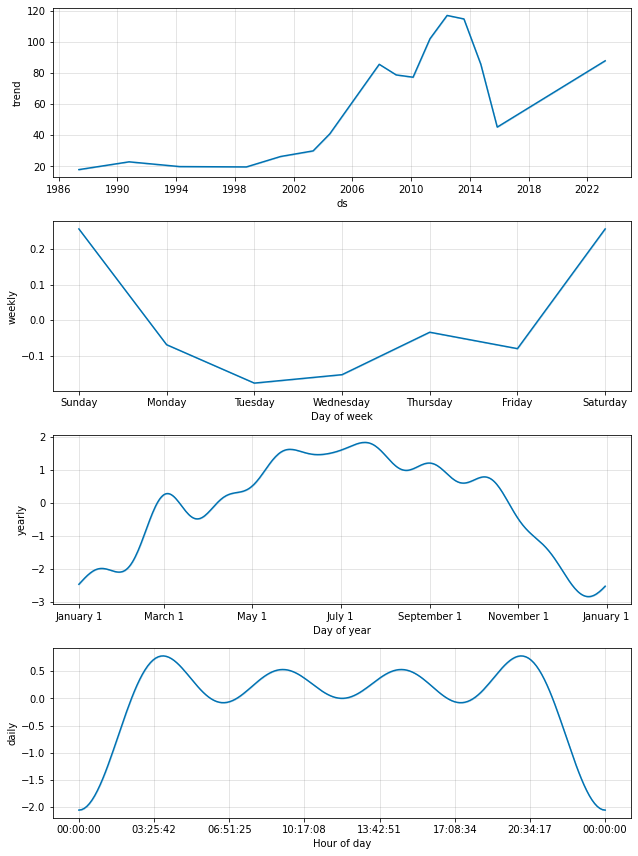

In [68]:
model.plot_components(forecast)


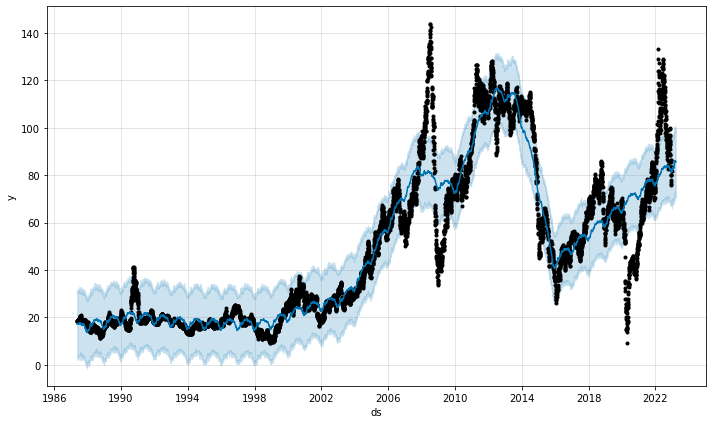

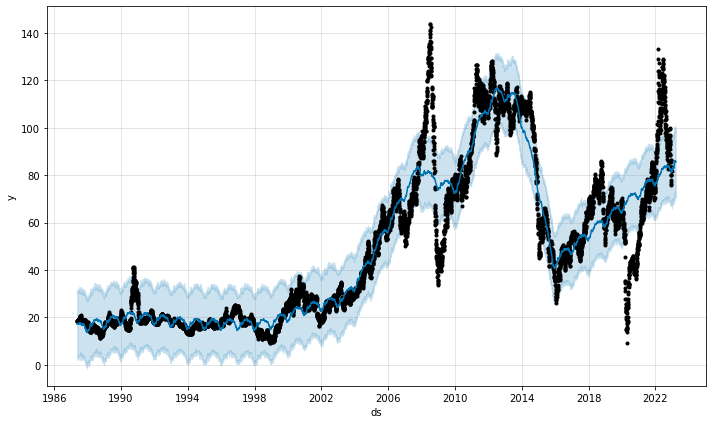

In [69]:
model.plot(forecast)

### Next we want to visualize side by side the original data and the forecast data. So for this, we join the original and forecast data on the column 'ds'

In [70]:
vis_df = forecast.set_index('ds')[['yhat','yhat_lower','yhat_upper']].join(model_df.set_index('ds'))

In [71]:
vis_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
1987-05-20,17.157918,4.068959,30.226774,18.63
1987-05-21,17.313350,3.132410,30.844685,18.45
1987-05-22,17.298025,3.282515,31.140135,18.55
1987-05-25,17.372698,3.169379,30.496342,18.60
1987-05-26,17.276649,3.631359,31.243137,18.63


In [76]:
y_true=model_df['y'].iloc[:9034]
y_predicted=vis_df['yhat'].iloc[:9034]
mae=mean_absolute_error(y_true, y_predicted)
r2=r2_score(y_true, y_predicted)
mse=mean_squared_error(y_true, y_predicted)
print('prophet accuracy using mean absolute error=', mae)
print('prophet accuracy using mean squared error=', mse)
print('prophet accuracy using r2 score=', r2)

prophet accuracy using mean absolute error= 6.830854658361459
prophet accuracy using mean squared error= 119.95576599718524
prophet accuracy using r2 score= 0.8889771568851085


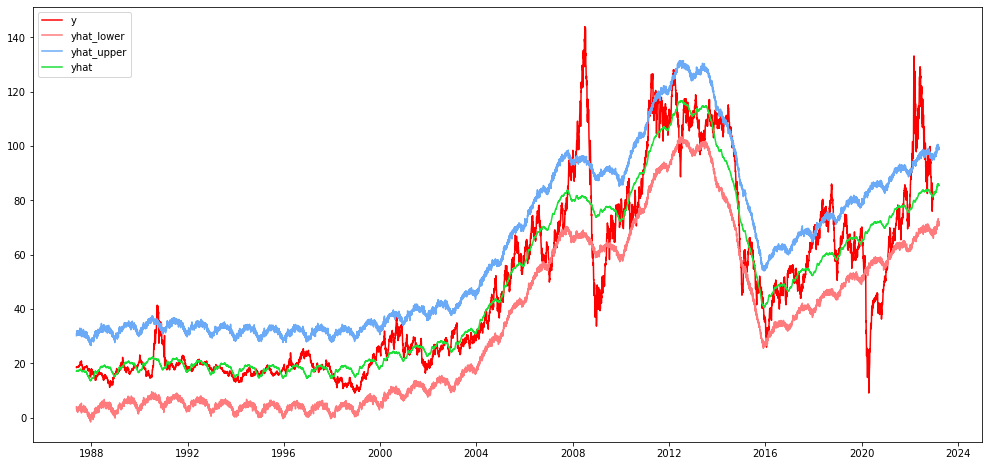

In [77]:
# Then, we visualize the original and forecast data alongside each other
plt.figure(figsize=(17,8))
label = ['y','yhat_lower','yhat_upper','yhat']
plt.plot(vis_df['y'],color='red')
plt.plot(vis_df['yhat_lower'],color='#ff7a7d')
plt.plot(vis_df['yhat_upper'],color='#6aaaf7')
plt.plot(vis_df['yhat'],color='#1be038')
plt.legend(label)
plt.show()

### From above graph, we are not able to readily see how many months data was forecast.

### So, We need a function which will show us the original and forecast data between a specified date range.

In [78]:
def plot_price_forecast(df,start_date, end_date):
    """
    This function filters the dataframe for the specified date range and 
    plots the actual and forecast data.
    
    Assumption: 
    - The dataframe has to be indexed on a Datetime column
    This makes the filtering very easy in pandas using df.loc
    """
    vis_df = df.loc[start_date:end_date]
    label = ['y','yhat']
    plt.figure(figsize=(17,8))
    plt.plot(vis_df['yhat'])
    plt.plot(vis_df['y'])
    plt.legend(label)
    plt.show()

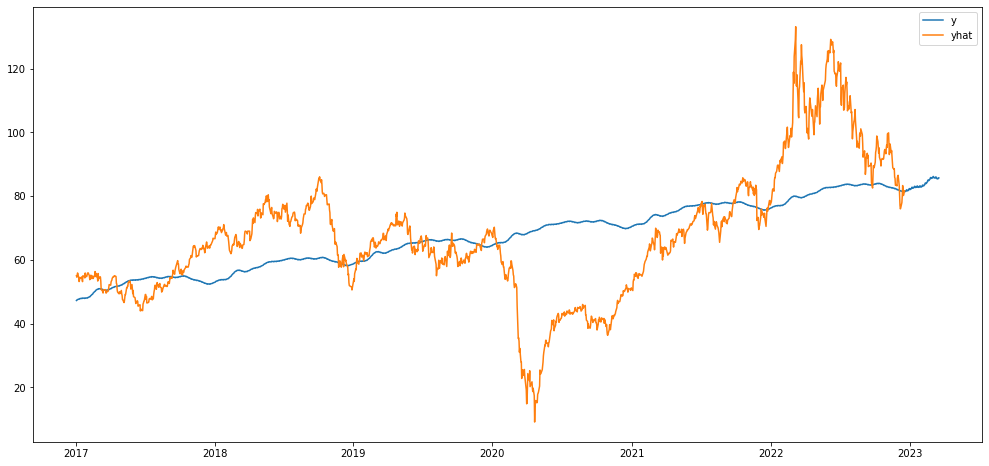

In [79]:
plot_price_forecast(vis_df, '2017-01-01', '2023-03-19')

### ARIMA

In [184]:
data = pd.read_excel('BrentOil.xlsx', parse_dates = True, index_col = 'Date')
data.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


### Setting the time frequency to fit the data

In [185]:
data = data.asfreq(freq='B')

In [186]:
missing_data=data.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print(missing_data[column].value_counts())

Price
False    9034
True      250
Name: Price, dtype: int64


In [187]:
data.fillna(method = 'bfill',inplace = True)
data.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [188]:
arima_df = data
arima_df.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


## Testing the the sationarity of the time series using Dicky-Fuller Test

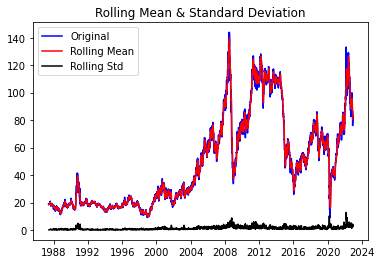

Results of Dickey-Fuller Test:
Test Statistic                   -2.141637
p-value                           0.228105
#Lags Used                       37.000000
Number of Observations Used    9246.000000
Critical Value (1%)              -3.431057
Critical Value (5%)              -2.861853
Critical Value (10%)             -2.566936
dtype: float64


In [189]:
test_stationarity(arima_df)

### Trying the first difference to make the data stationary

In [190]:
first_diff = arima_df.diff()[1:]
first_diff.head()

,Price
Date,
1987-05-21,-0.18
1987-05-22,0.10
1987-05-25,0.05
1987-05-26,0.03
1987-05-27,-0.03


Text(0, 0.5, 'price')

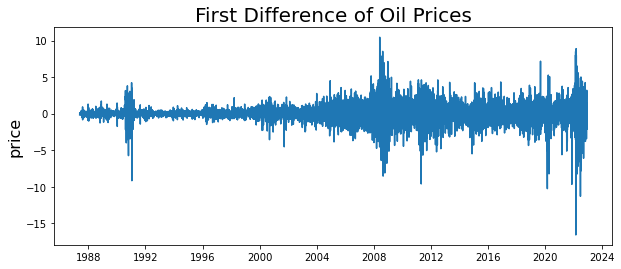

In [191]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of Oil Prices', fontsize=20)
plt.ylabel('price', fontsize=16)

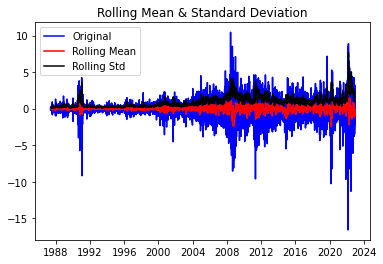

Results of Dickey-Fuller Test:
Test Statistic                -1.369646e+01
p-value                        1.314133e-25
#Lags Used                     3.800000e+01
Number of Observations Used    9.244000e+03
Critical Value (1%)           -3.431058e+00
Critical Value (5%)           -2.861853e+00
Critical Value (10%)          -2.566936e+00
dtype: float64


In [192]:
test_stationarity(first_diff)

### Plotting the ACF and PCF plots for ARIMA

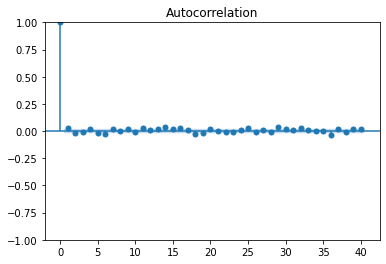

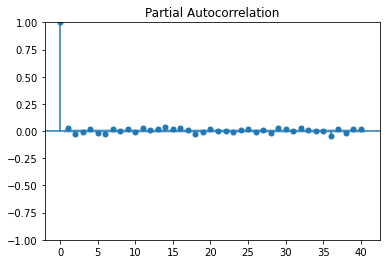

In [193]:
acf_plot=plot_acf(first_diff)
pacf_plot=plot_pacf(first_diff)

### Splitting the data into Train and Test 

In [194]:
train_end = datetime(2019,1,1)
test_end = datetime(2022,12,19)

X_train = data[:train_end]
X_test = data[train_end + timedelta(days=1):test_end]
X_train

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2018-12-26,51.49
2018-12-27,51.49
2018-12-28,50.57


### For Differencing

In [195]:
train_end = datetime(2019,1,1)
test_end = datetime(2022,12,19)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]
test_data

,Price
Date,
2019-01-02,0.00
2019-01-03,-0.83
2019-01-04,2.41
2019-01-07,1.46
2019-01-08,-0.19
...,...
2022-12-13,2.14
2022-12-14,3.19
2022-12-15,-0.99


### ARIMA Hyperparameter tuning

In [196]:
import pmdarima as pmd

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              trace=True)
    return autoarima_model

In [197]:
arima_model_diff = arimamodel(train_data)
arima_model_diff.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=24261.729, Time=1.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=24261.696, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24259.733, Time=0.47 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24259.729, Time=0.87 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24259.834, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=24261.729, Time=1.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=24263.728, Time=1.36 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=24257.861, Time=0.32 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=24259.860, Time=0.43 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=24259.860, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=24257.864, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=24261.860, Time=0.72 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 7.466 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8249
Model:               SARIMAX(0, 0, 1)   Log Likelihood              -12126.930
Date:                Tue, 03 Jan 2023   AIC                          24257.861
Time:                        12:34:02   BIC                          24271.896
Sample:                             0   HQIC                         24262.657
                               - 8249                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0219      0.007      3.003      0.003       0.008       0.036
sigma2         1.1078      0.007    149.833      0.000       1.093       1.122
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             27576.02
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.22   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [198]:
model1 = ARIMA(train_data, order = (0,0,1))

In [199]:
model_fit = model1.fit()

In [200]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 8249
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -12126.865
Date:                Tue, 03 Jan 2023   AIC                          24259.729
Time:                        12:34:04   BIC                          24280.783
Sample:                    05-21-1987   HQIC                         24266.924
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.012      0.361      0.718      -0.019       0.028
ma.L1          0.0219      0.007      2.997      0.003       0.008       0.036
sigma2         1.1077      0.007    149.520      0.0

### Forecasting using ARIMA

In [201]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [202]:
predictions = model_fit.predict(start = pred_start_date, end = pred_end_date)
predictions

2019-01-02    0.002510
2019-01-03    0.004291
2019-01-04    0.004291
2019-01-07    0.004291
2019-01-08    0.004291
                ...   
2022-12-13    0.004291
2022-12-14    0.004291
2022-12-15    0.004291
2022-12-16    0.004291
2022-12-19    0.004291
Freq: B, Name: predicted_mean, Length: 1034, dtype: float64

In [203]:
predictions = pd.DataFrame(predictions)
headers=['predictions']
predictions.columns=headers
predictions.head()

,predictions
2019-01-02,0.002510
2019-01-03,0.004291
2019-01-04,0.004291
2019-01-07,0.004291
2019-01-08,0.004291


In [204]:
predictions.index.names = ['Date']
predictions

,predictions
Date,
2019-01-02,0.002510
2019-01-03,0.004291
2019-01-04,0.004291
2019-01-07,0.004291
2019-01-08,0.004291
...,...
2022-12-13,0.004291
2022-12-14,0.004291
2022-12-15,0.004291


In [205]:
result=pd.merge(test_data, predictions, on='Date')
result.head()

,Price,predictions
Date,,
2019-01-02,0.00,0.002510
2019-01-03,-0.83,0.004291
2019-01-04,2.41,0.004291
2019-01-07,1.46,0.004291
2019-01-08,-0.19,0.004291


In [206]:
result['residuals']=result['Price']-result['predictions']
result.head()

,Price,predictions,residuals
Date,,,
2019-01-02,0.00,0.002510,-0.002510
2019-01-03,-0.83,0.004291,-0.834291
2019-01-04,2.41,0.004291,2.405709
2019-01-07,1.46,0.004291,1.455709
2019-01-08,-0.19,0.004291,-0.194291


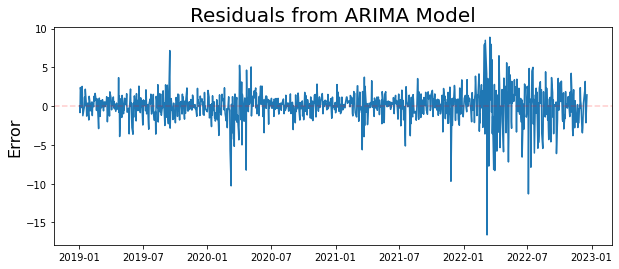

In [207]:
plt.figure(figsize=(10,4))
plt.plot(result['residuals'])
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

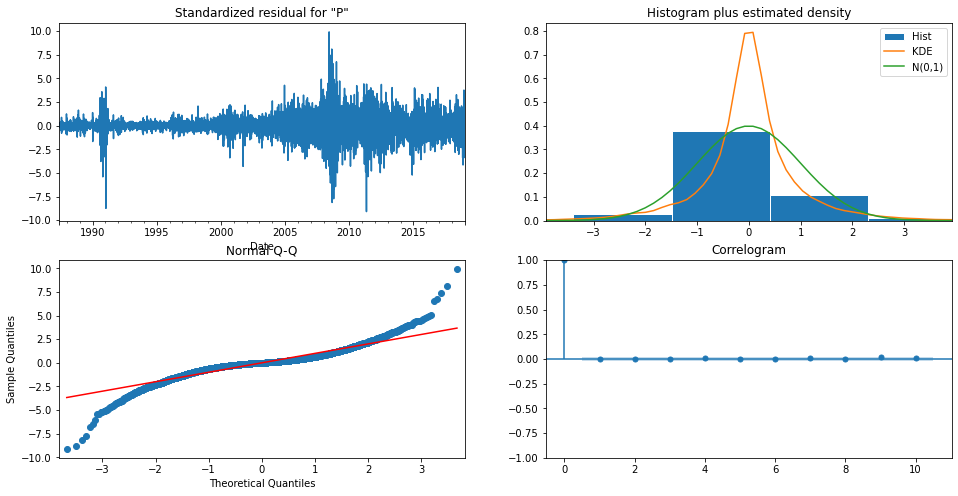

In [208]:
model_fit.plot_diagnostics(figsize=(16,8))
plt.show()

In [209]:
print('Root Mean Squared Error:', numpy.sqrt(numpy.mean(result['residuals']**2)))

Root Mean Squared Error: 2.030528979818078


In [210]:
result['actual_price']=arima_df['Price']
result['predicted_price']=arima_df['Price']
for interval in range(0, len(result)-1):
    result['predicted_price'][interval+1]=result['predictions'][interval+1]+result['actual_price'][interval]
result.head()

,Price,predictions,residuals,actual_price,predicted_price
Date,,,,,
2019-01-02,0.00,0.002510,-0.002510,54.06,54.060000
2019-01-03,-0.83,0.004291,-0.834291,53.23,54.064291
2019-01-04,2.41,0.004291,2.405709,55.64,53.234291
2019-01-07,1.46,0.004291,1.455709,57.10,55.644291
2019-01-08,-0.19,0.004291,-0.194291,56.91,57.104291


Text(0, 0.5, 'Price')

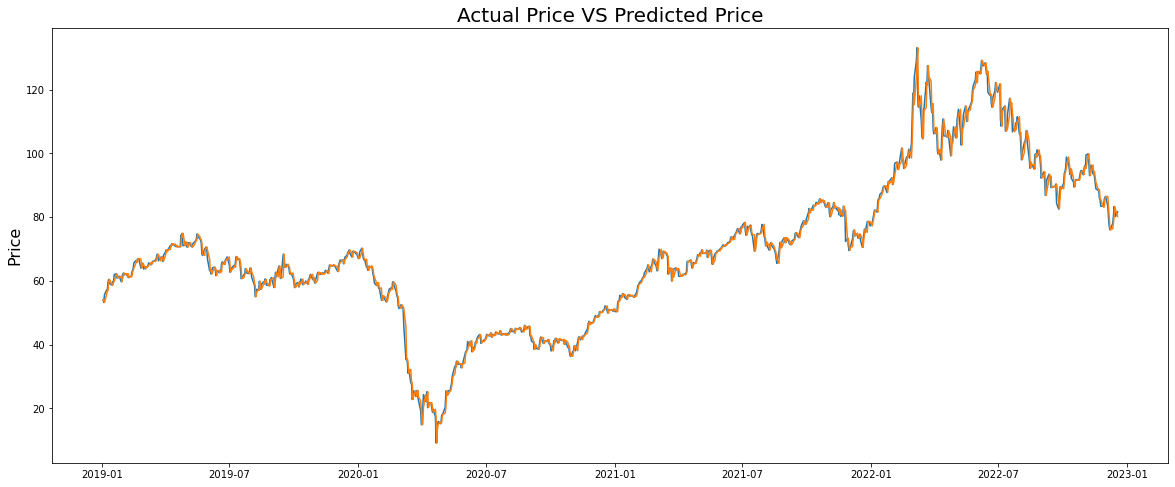

In [211]:
plt.figure(figsize=(20,8))
plt.plot(result['actual_price'])
plt.plot(result['predicted_price'])
plt.title('Actual Price VS Predicted Price', fontsize=20)
plt.ylabel('Price', fontsize=16)

In [212]:
y_true=result['actual_price']
y_predicted=result['predicted_price']
mae=mean_absolute_error(y_true, y_predicted)
r2=r2_score(y_true, y_predicted)
mse=mean_squared_error(y_true, y_predicted)
print('ARIMA accuracy using mean absolute error=', mae)
print('ARIMA accuracy using mean squared error=', mse)
print('ARIMA accuracy using r2 score=', r2)

ARIMA accuracy using mean absolute error= 1.3362789522592255
ARIMA accuracy using mean squared error= 4.123047931786809
ARIMA accuracy using r2 score= 0.9925153754858762


### Visualizing the Relationship between the Actual and Predicted ValuesModel Validation

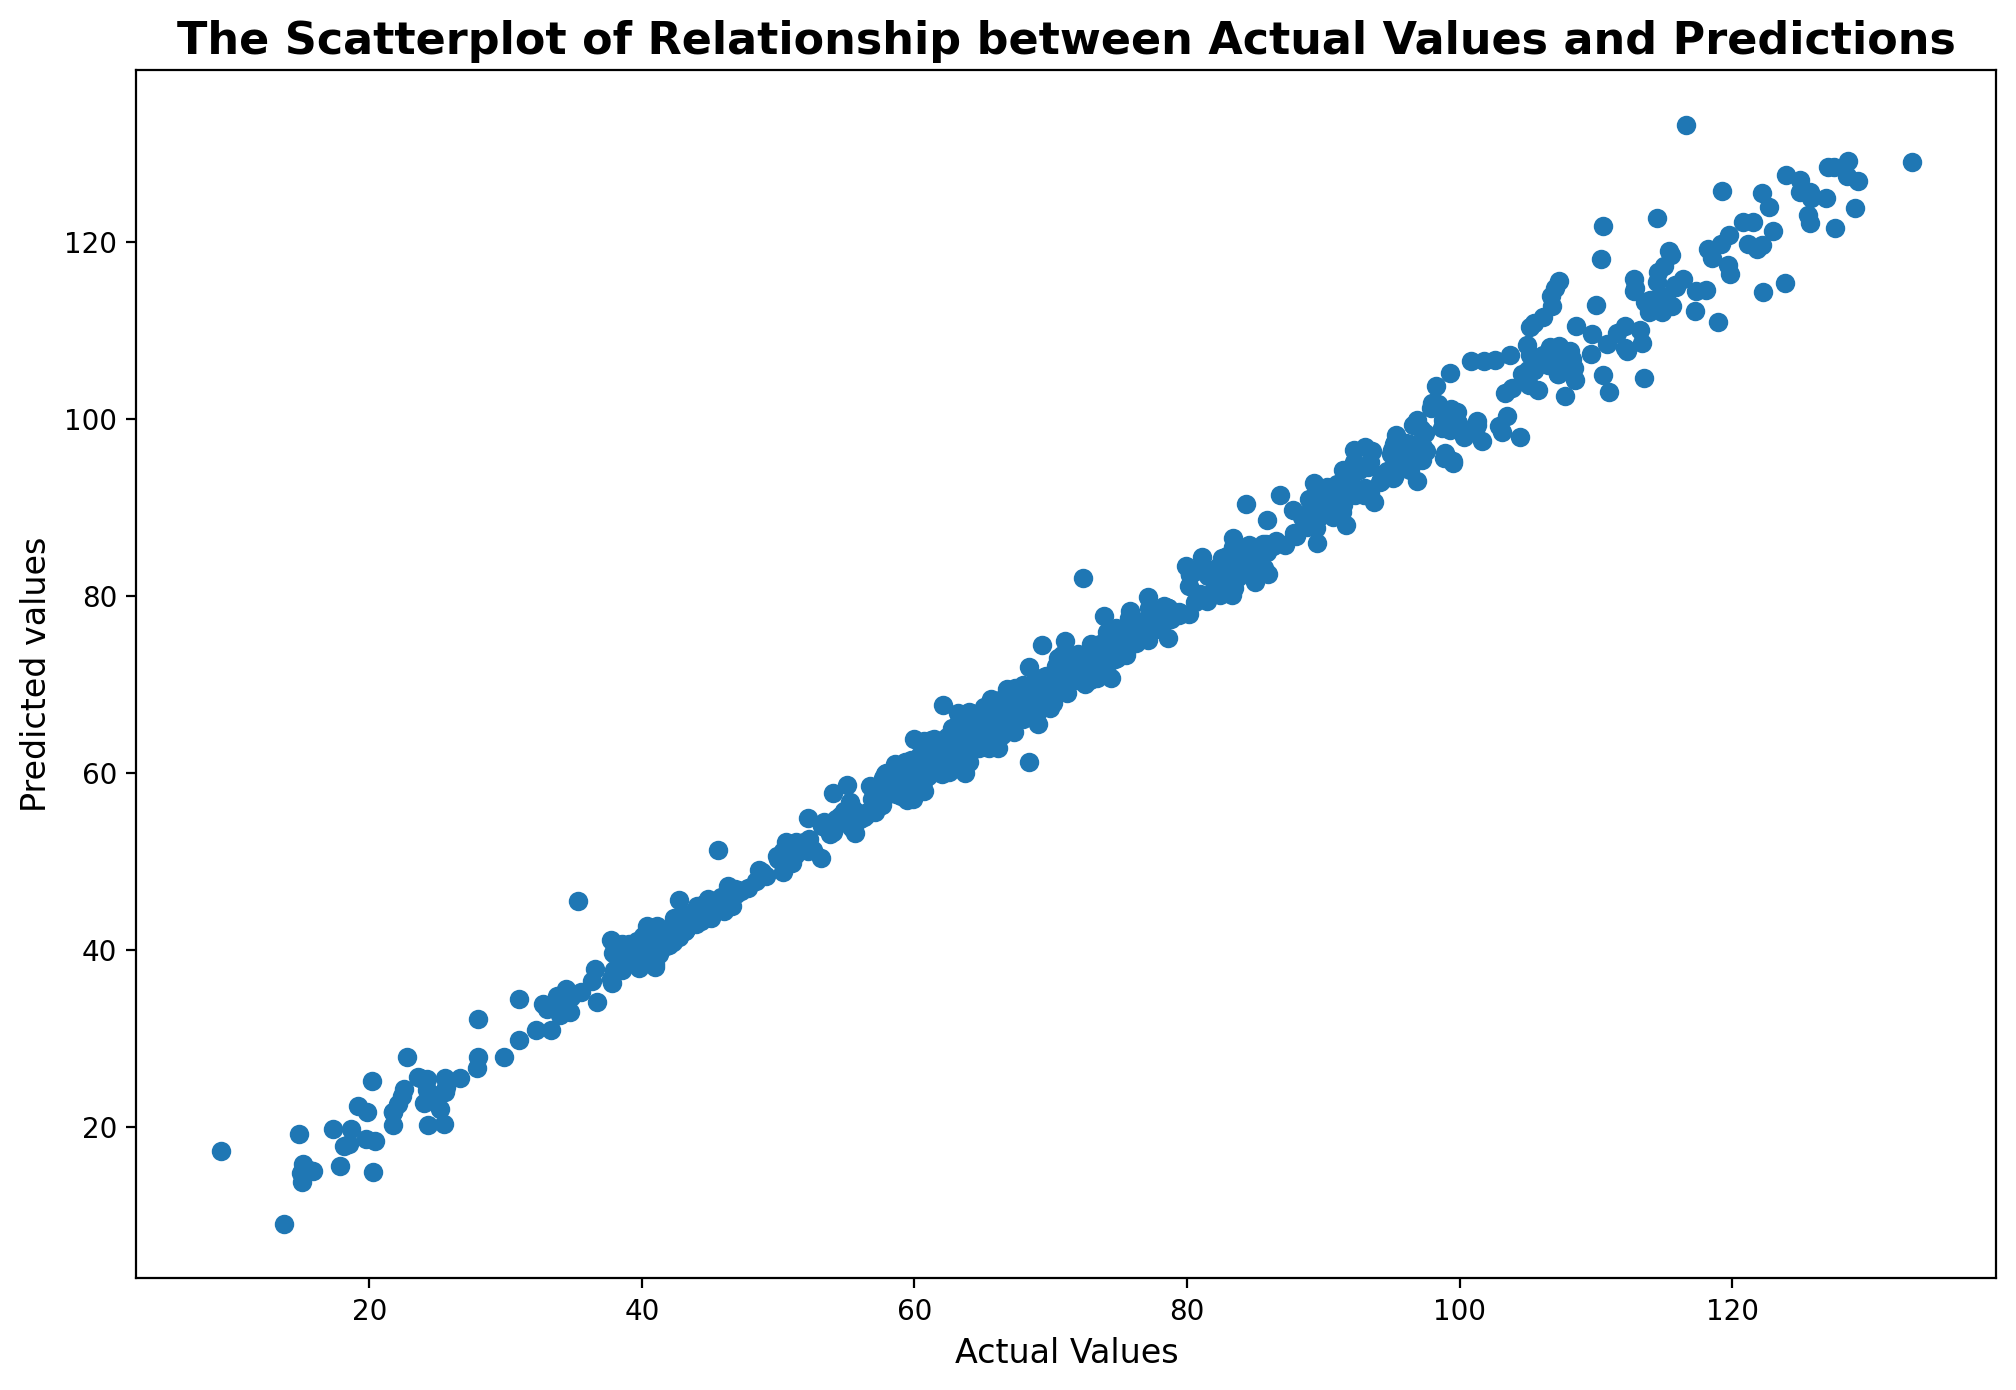

In [213]:
plt.figure(figsize=(12,8), dpi=200)
plt.xlabel("Actual Values", fontsize =12)
plt.ylabel("Predicted values", fontsize =12)
plt.title("The Scatterplot of Relationship between Actual Values and Predictions", fontsize =16, fontweight = 'bold')
plt.scatter(result['actual_price'], result['predicted_price'])
plt.show()

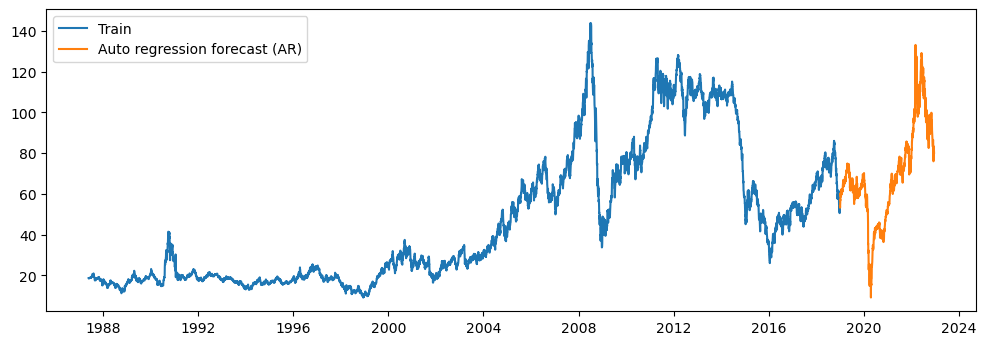

In [214]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(X_train['Price'], label='Train')
# plt.plot(test_data['Price'], label='Test')
plt.plot(result['predicted_price'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

### Forecasting prices for next 3 months

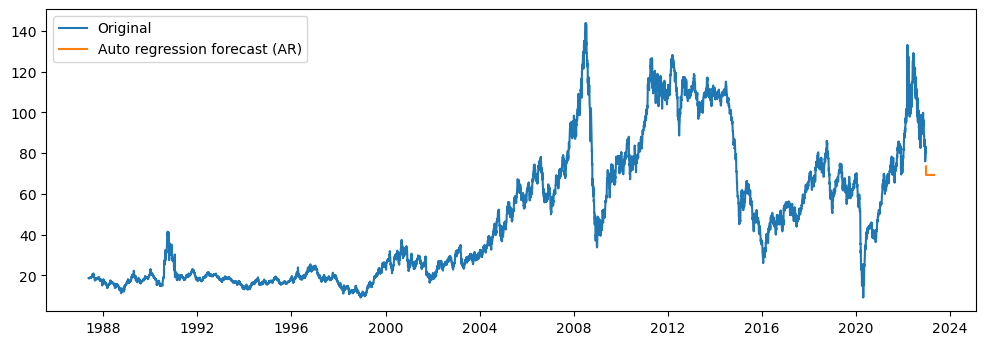

In [215]:
final_model = ARIMA(result['actual_price'], order=(0, 0, 1))
final_model_fit = final_model.fit()
forecast = pd.DataFrame()
forecast['arima_forecast'] = final_model_fit.predict(start = 1034, end = 1124)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(data['Price'], label='Original')
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

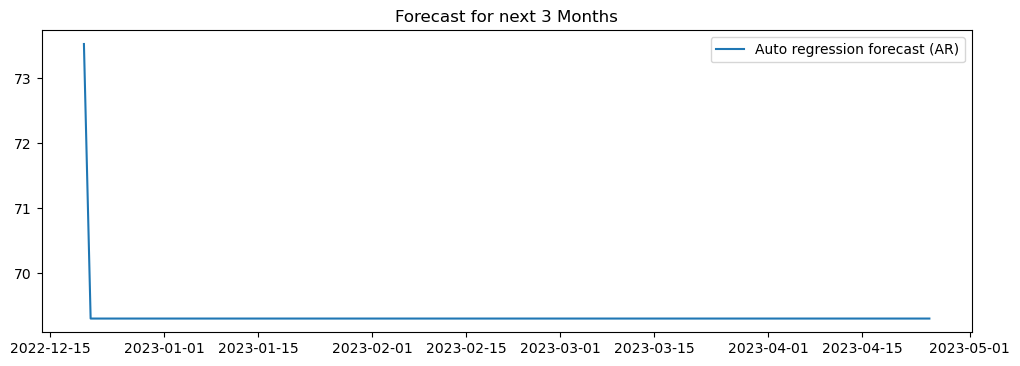

In [216]:
plt.figure(figsize=(12,4), dpi=100)
plt.plot(forecast['arima_forecast'], label='Auto regression forecast (AR)')
plt.title('Forecast for next 3 Months')
plt.legend(loc='best')
plt.show()